In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from datetime import date, datetime, timedelta
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import seaborn as sns

In [2]:
# download CMT treasury curves from Fred
codes = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
start_date = datetime(2000, 12, 20)
# end_date = datetime.today()
end_date = datetime(2020,12,31)

df = pd.DataFrame()

for code in codes:
    reader = FredReader(code, start_date, end_date)
    df0 = reader.read()
    df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)

df.dropna(axis = 0, inplace = True)
df = df['2006':] # '06 and fwd

In [ ]:
df.tail(5)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df);

In [ ]:
df_weekly = df.resample("W").last()
df_weekly.tail()
df_weekly_centered = df_weekly.sub(df_weekly.mean())
df_weekly_diff = df_weekly.diff()
df_weekly_diff.dropna(inplace=True)
df_weekly_diff_centered = df_weekly_diff.sub(df_weekly_diff.mean())
df_weekly.shape, df_weekly_diff.shape

In [ ]:
df_weekly_diff.cov()
df_weekly_diff.corr()

In [18]:
from sklearn.decomposition import PCA
pca_level = PCA().fit(df_weekly)
pca_change = PCA().fit(df_weekly_diff)

In [ ]:
#print(pca_change.explained_variance_) # eigenvalues
#print(pca_change.explained_variance_ratio_) # eigenvalue / sum(eigenvalue)
#print(pca_change.explained_variance_ratio_.cumsum())

print(pd.DataFrame(pca_change.explained_variance_ratio_.cumsum(), columns = ['Cumulative Exp Var']))

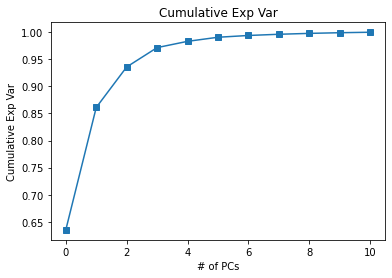

In [56]:
plt.plot(pca_change.explained_variance_ratio_.cumsum(),"-s");
plt.title("Cumulative Exp Var")
plt.xlabel('# of PCs');
plt.ylabel('Cumulative Exp Var');

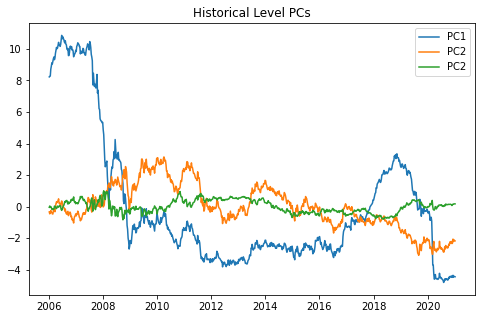

In [80]:
df_pca_level = pca_level.transform(df_weekly) # transform -> score matrix; uses mean from .fit() to center but doesn't scale by s.d.
df_pca_level = pd.DataFrame(df_pca_level, columns=[f'PCA_{x+1}' for x in range(df_pca_level.shape[1])])  # output into dataframe, rename with f string
df_pca_level.index = df_weekly.index

plt.figure(figsize=(8,5))
plt.title("Historical Level PCs")
plt.plot(df_pca_level['PCA_1'], label='PC1')
plt.plot(df_pca_level['PCA_2'], label='PC2')
plt.plot(df_pca_level['PCA_3'], label='PC2')  
plt.legend()
plt.show();

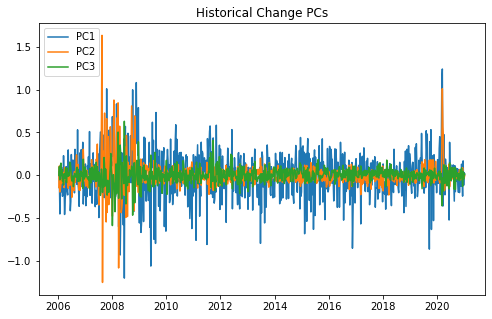

In [81]:
df_pca_change = pca_change.transform(df_weekly_diff)
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PCA_{x+1}' for x in range(df_pca_change.shape[1])])
df_pca_change.index = df_weekly_diff.index

plt.figure(figsize=(8,5))
plt.title("Historical Change PCs")
plt.plot(df_pca_change['PCA_1'], label='PC1')
plt.plot(df_pca_change['PCA_2'], label='PC2')
plt.plot(df_pca_change['PCA_3'], label='PC3')
plt.legend()
plt.show();

In [ ]:
# print(pca_change.singular_values_)
# print(pca_change.get_covariance())
print(pd.DataFrame(pca_change.components_.T)) # note .components_ is s.t. ith row is PCi's loading vector 

In [ ]:
# checkpoint
print(df_pca_change.iloc[:3,:3]) # show PC score / value of each PC; score = centered(df) * .components_.T
print(np.matmul(df_weekly_diff_centered, pca_change.components_.T).iloc[:3, :3]) # centered(df) * .components_.T, should be same as above, ignore col names
print(np.matmul(pca_change.components_, pca_change.components_.T)[1,1]) # should both be 1 / entry from I
print(np.matmul(pca_change.components_.T, pca_change.components_)[2,2])

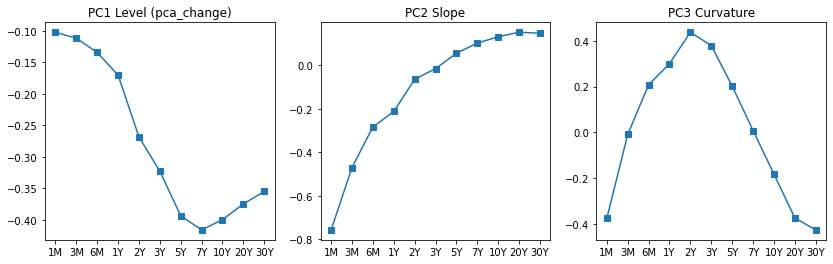

In [140]:
tenors_label = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(14,4))
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors_label, pca_change.components_[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors_label, pca_change.components_[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors_label, pca_change.components_[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors fall, 7y the most (-0.4bps)
